# Discriminator Tutorial

In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import Discriminator
from qiskit_experiments.measurement.discriminator import DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment
from qiskit.providers.backend import BackendV1 as Backend
from typing import List, Tuple
from qiskit.providers.options import Options
from qiskit.qobj.utils import MeasLevel

from qiskit import QuantumCircuit
from qiskit_experiments.test.mock_iq_backend import MockIQBackend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
class DiscriminatorBackend(MockIQBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self, iq_cluster_centers: Tuple[float, float, float, float] = (1.0, 1.0, -1.0, -1.0),iq_cluster_width: float = 0.2):
        """
        Initialize the discriminator backend
        """
        super().__init__(iq_cluster_centers, iq_cluster_width)

    def _compute_probability(self, circuit: QuantumCircuit) -> float:
        """Returns the probability based on the frequency."""
        if circuit.data[-1][0].name == "x":
            return 1
        elif circuit.data[-1][0].name == "measure":
            return 0


## Run Example Discriminator Experiment on One Qubit

---------------------------------------------------
Experiment: Discriminator
Experiment ID: f935d982-5fb7-4caa-8001-5ae637550854
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: LinearDiscriminantAnalysis()
- coef: [[-1.00300218  0.10658748]]
- intercept: [-0.90116479]
- score: 0.565
- success: True


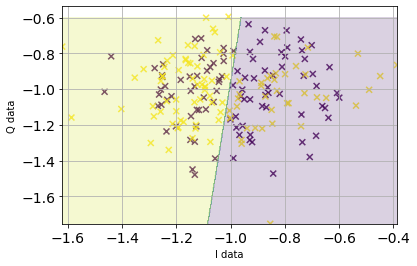

In [20]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
lda_res = exp.run(
    backend,
    shots=100
)

print(lda_res)

---------------------------------------------------
Experiment: Discriminator
Experiment ID: 52e6d36f-9434-4f62-9b88-e45c9b851fad
Status: DONE
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- discriminator: QuadraticDiscriminantAnalysis()
- rotations: [array([[-0.74833745,  0.66331822],
       [-0.66331822, -0.74833745]]), array([[ 0.99831838,  0.05796911],
       [ 0.05796911, -0.99831838]])]
- score: 0.59
- success: True


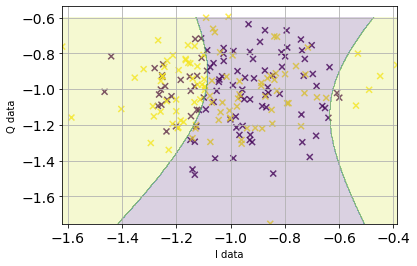

In [21]:
backend = DiscriminatorBackend()
exp = Discriminator(1)
exp.set_analysis_options(discriminator_type="QDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
qda_res = exp.run(
    backend,
    shots=100
)

print(qda_res)

## Run Discriminator Experiments in Parallel 

In [11]:
from qiskit_experiments.measurement.discriminator import Discriminator, DiscriminatorAnalysis
from qiskit_experiments.composite import ParallelExperiment

exps = [Discriminator(i) for i in range(2)]

par_exp = ParallelExperiment(exps)
par_expdata = par_exp.run(backend, shots=100)
print(par_expdata)

QiskitError: 'indices must be in range [0, 0].'

## Use Data Processor Discriminator Node

In [22]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)

# LDA node
processor = DataProcessor("memory", [Discriminator(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminator(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

(0.53, 0.04990991885387112)
(0.7, 0.045825756949558406)


Using a parallel experiment to discriminate over multiple qubits:

In [23]:
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

NameError: name 'par_expdata' is not defined

In [36]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToImag,
    Probability,
    Discriminator
)
processor = DataProcessor("memory", [Discriminator(par_expdata)])
processor.append(Probability("000"))
datum = processor(par_expdata.data(0))

print(datum)

[autoreload of qiskit_experiments.data_processing.nodes failed: Traceback (most recent call last):
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-workshop/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/Helena.Zhang@ibm.com/Documents/GitHub/playground/pydantic-w

TypeError: _process() takes from 2 to 3 positional arguments but 101 were given